In [1]:
import pyflux as pf
import pandas as pd

In [2]:
def clean_raw(bc_full_df):
    #alsways drop these cols
    bc_full_df = bc_full_df.drop('Worksheet Filter',axis=1)
    bc_full_df = bc_full_df.drop('Measure Display',axis=1)
    bc_full_df = bc_full_df.drop('Number of Records',axis=1)
    bc_full_df = bc_full_df.drop('Unnamed: 0',axis=1)
    bc_full_df = bc_full_df.drop('State',axis=1)
    bc_full_df = bc_full_df.drop('Table Id',axis=1)
    bc_full_df = bc_full_df.drop('Period Duration',axis=1)
    bc_full_df = bc_full_df.drop('Period Begin',axis=1)
    
    #drop when doing neighborhoods
#     bc_full_df = bc_full_df.drop('months_of_supply',axis=1)
#     bc_full_df = bc_full_df.drop('months_of_supply_yoy',axis=1)
#     bc_full_df = bc_full_df.drop('months_of_supply_mom',axis=1)
#     bc_full_df = bc_full_df.drop('Price Drops',axis=1)
#     bc_full_df = bc_full_df.drop('Price Drops Yoy',axis=1)
#     bc_full_df = bc_full_df.drop('Price Drops Mom',axis=1)

    #drop 2nd date col
    dates = ['Period End'] #dropped Period End
    for col in dates:
        bc_full_df[col] = pd.to_datetime(bc_full_df[col])
    
    #format percent cols
    percents = ['Median Sale Price Mom',
    'Median Sale Price Yoy',
    'New Listings Mom',
    'New Listings Yoy',
    'Homes Sold Mom',
    'Homes Sold Yoy',
    'Inventory Mom',
    'Inventory Yoy',
    'Avg Sale To List Mom',
    'Avg Sale To List Yoy']
    for col in percents:
        bc_full_df[col] = bc_full_df[col].str.strip('%')
        bc_full_df[col] = pd.to_numeric(bc_full_df[col])
        
    #format money cols
    prices = ['Median Sale Price']
    for col in prices:
        bc_full_df[col] = bc_full_df[col].str.strip('$').str.strip('K').str.replace(',','')
        bc_full_df[col] = pd.to_numeric(bc_full_df[col])
    
    #change scale
    bc_full_df['Median List Price'] = bc_full_df['Median List Price'] / 1000.0
    
    #set index
    bc_full_df = bc_full_df.sort_values('Period End')
    bc_full_df = bc_full_df.set_index('Period End')
    
    return bc_full_df

In [403]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline

def decomp(series,trend=False,seas=False,resid=False,model='add'):
    df = pd.DataFrame()
    col_decomp = sm.tsa.seasonal_decompose(series, model=model,two_sided=False)
    #df[col] = col_decomp.observed
    if trend:
        df[series.name+' Trend'] = col_decomp.trend
    if seas:
        df[series.name+' Seasonal'] = col_decomp.seasonal
    if resid:
        df[series.name+' Residual'] = col_decomp.resid
    return df

# Read in data

In [1012]:
df = pd.read_csv('./bost_camb_full.csv')
df = clean_raw(df)
bos = df.copy()
mask = ((bos['Region'] == 'Boston, MA') &
       (bos['Property Type'] == 'All Residential'))
bos = bos[mask]
bos = bos.drop([col for col in bos.columns if bos[col].dtype == 'object'],axis=1)

In [1013]:
bos_arima = bos.copy()

# Quick look at trends of all variables

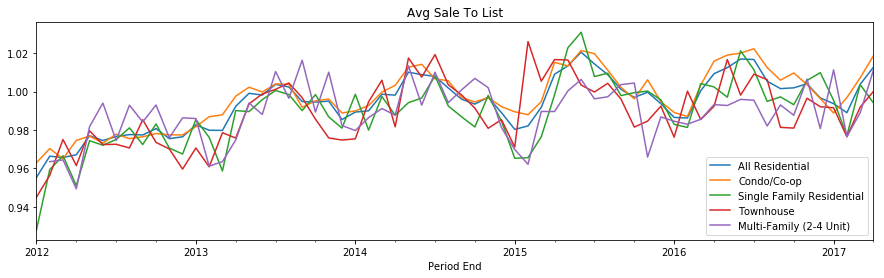

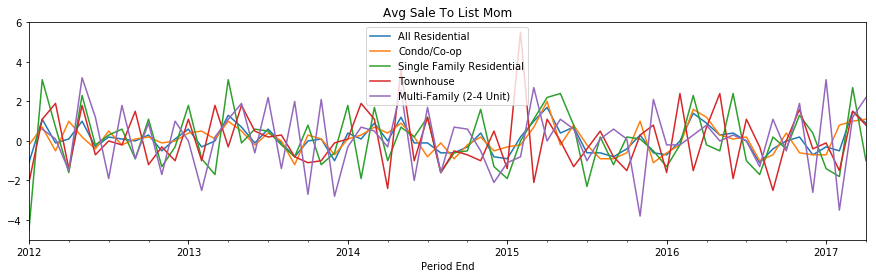

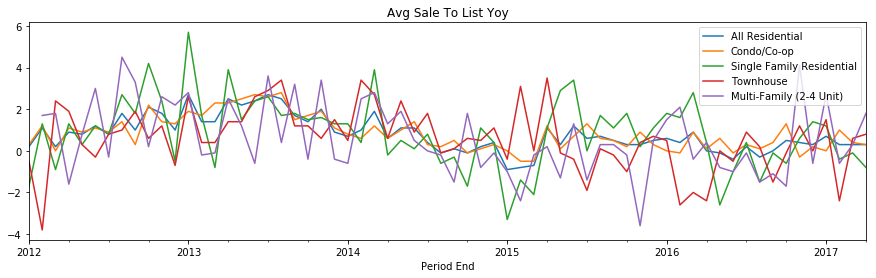

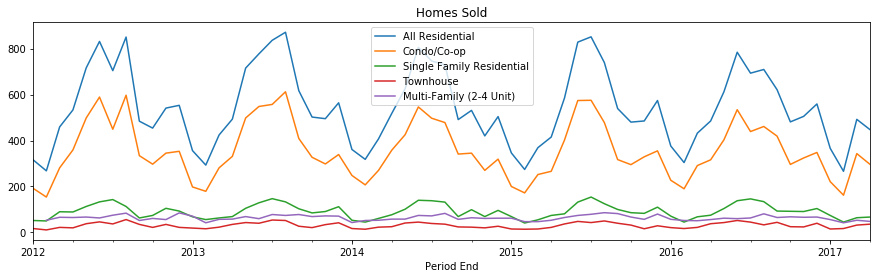

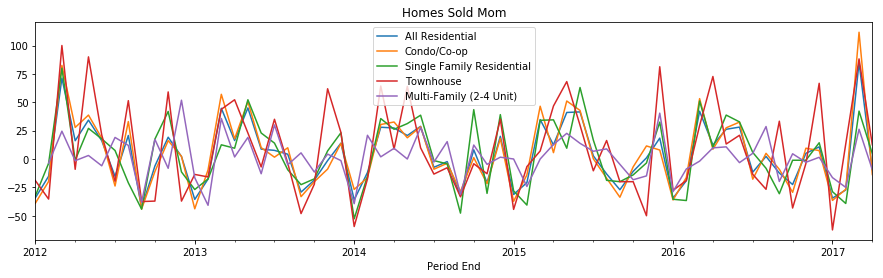

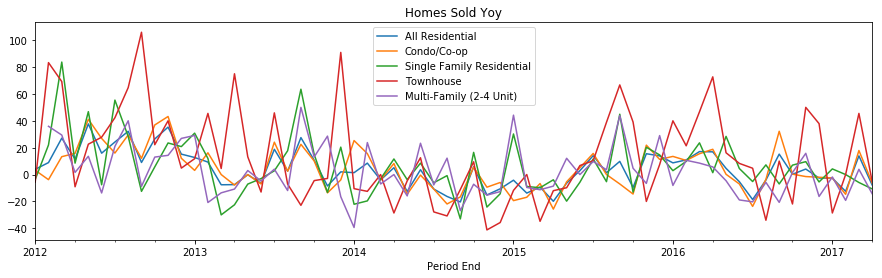

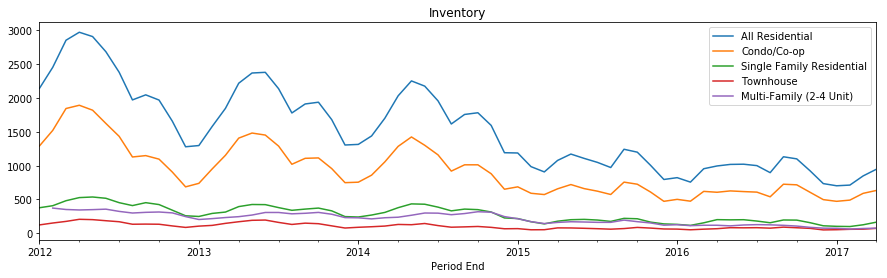

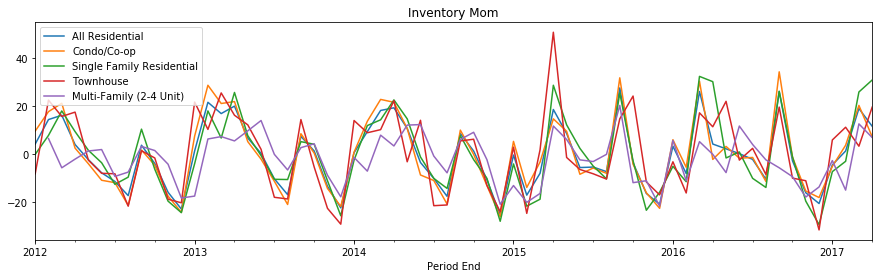

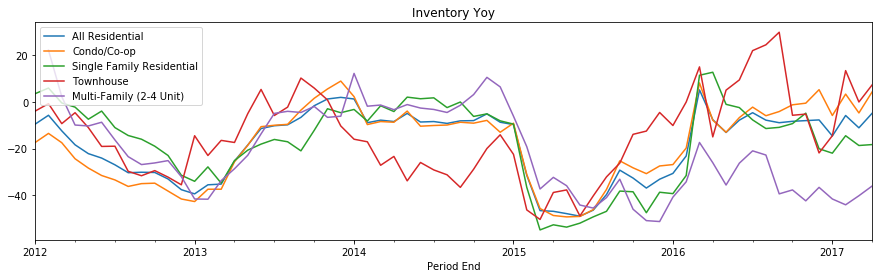

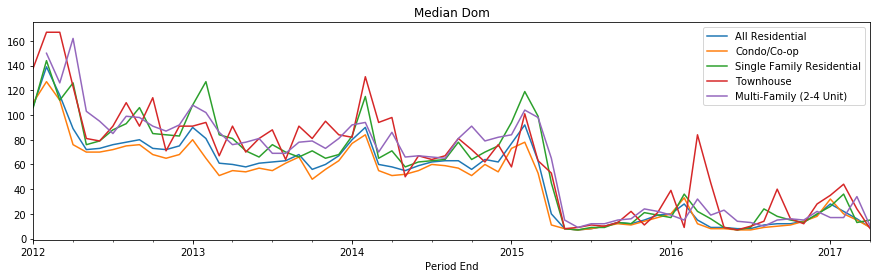

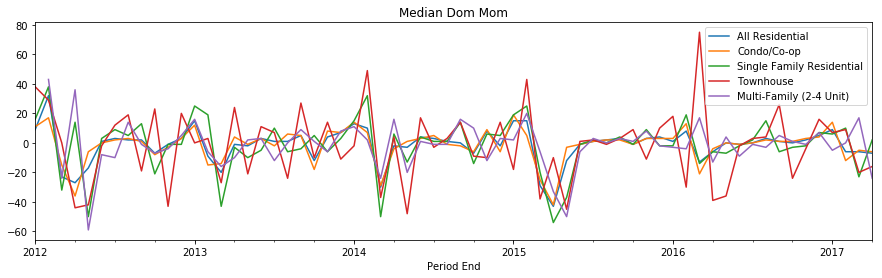

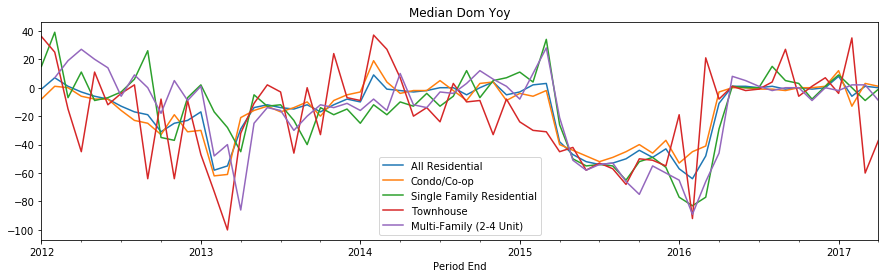

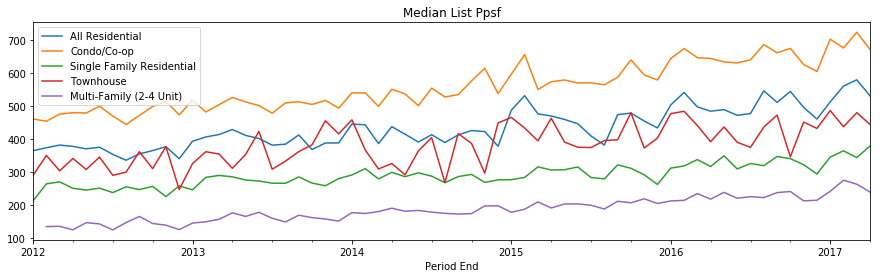

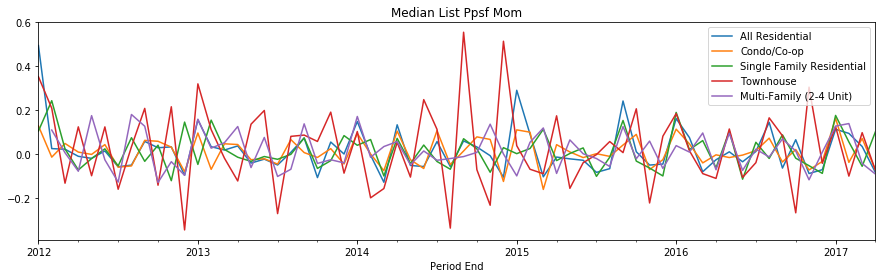

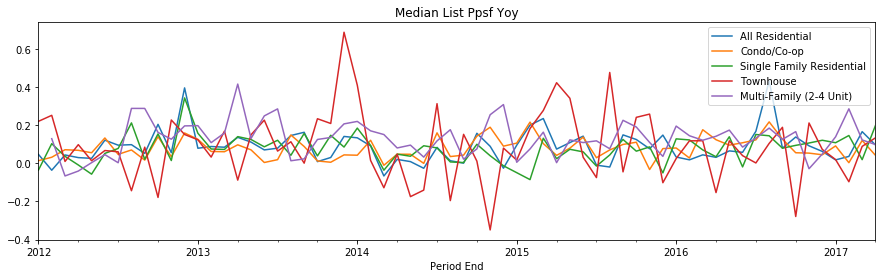

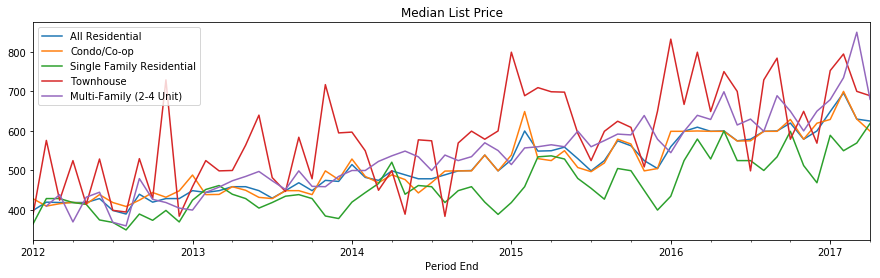

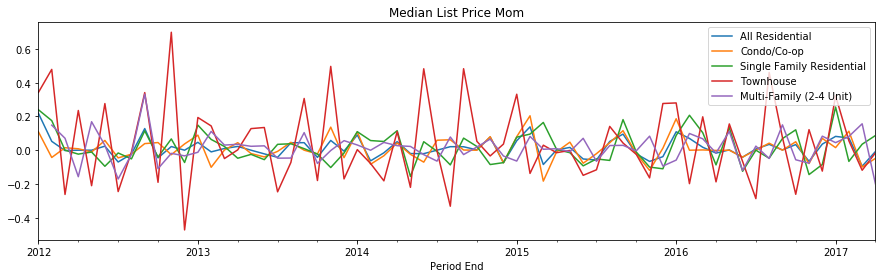

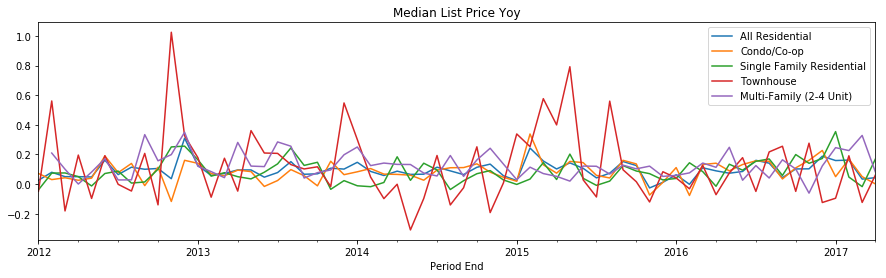

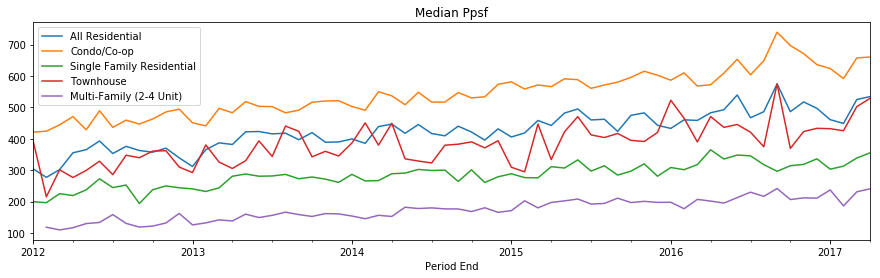

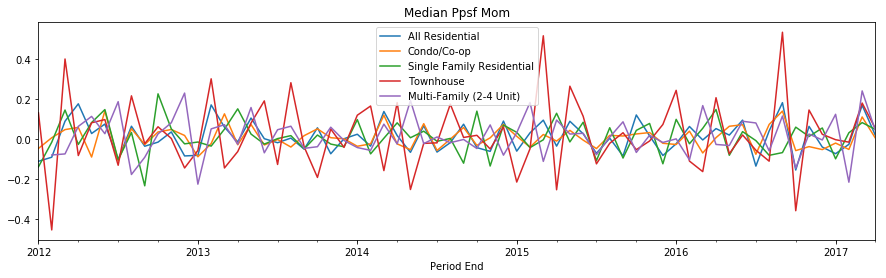

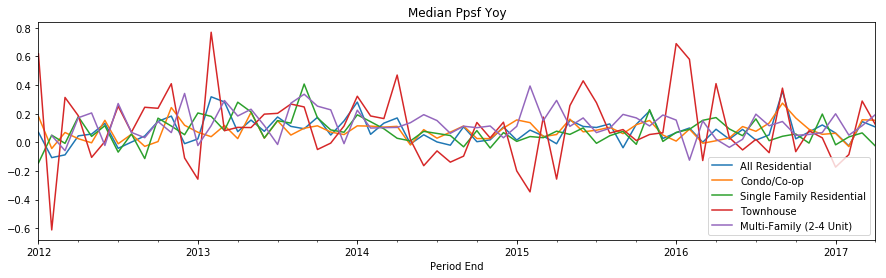

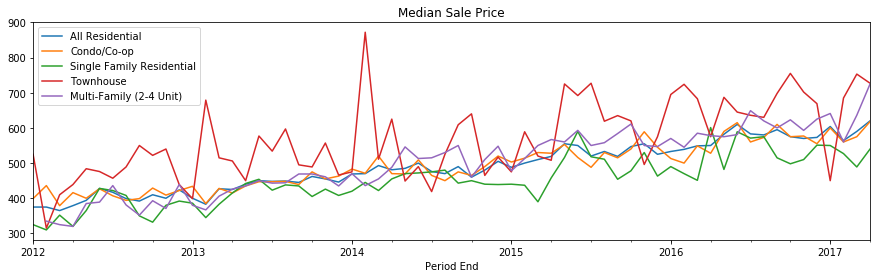

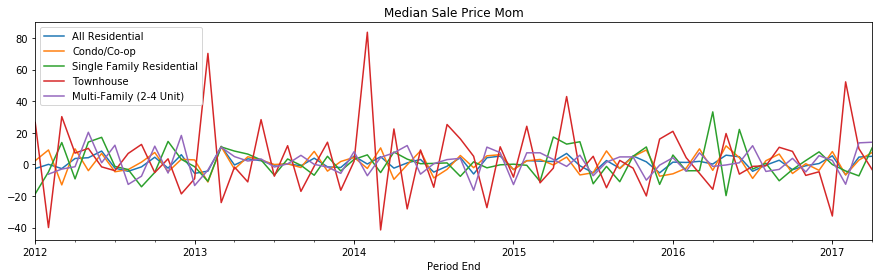

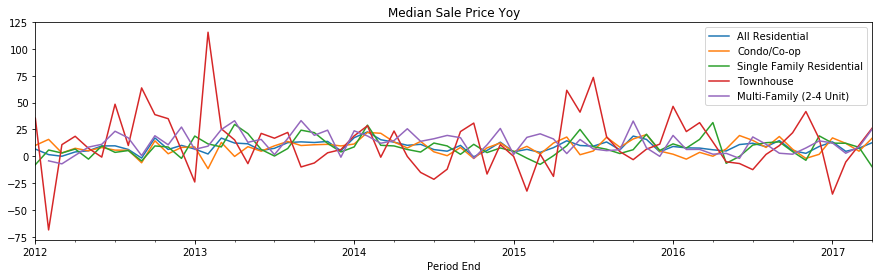

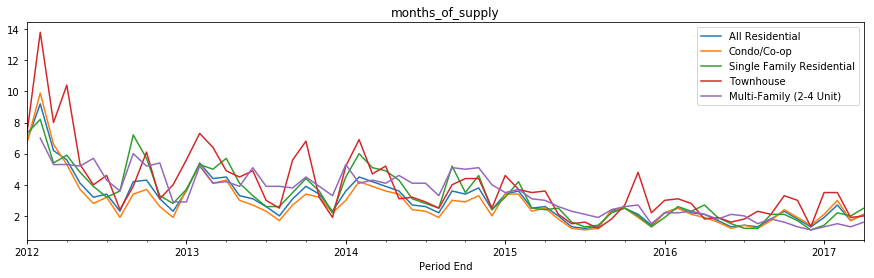

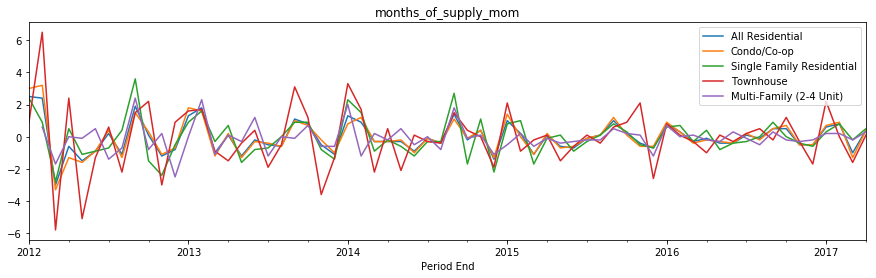

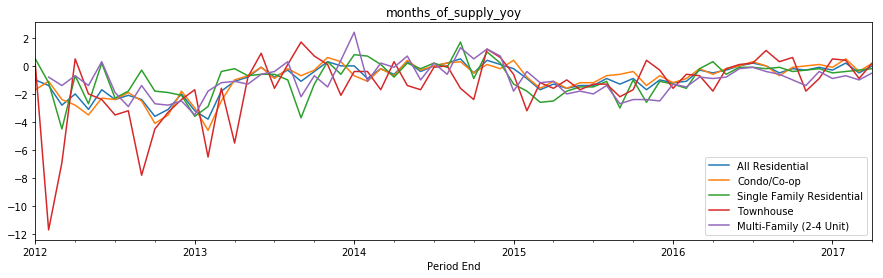

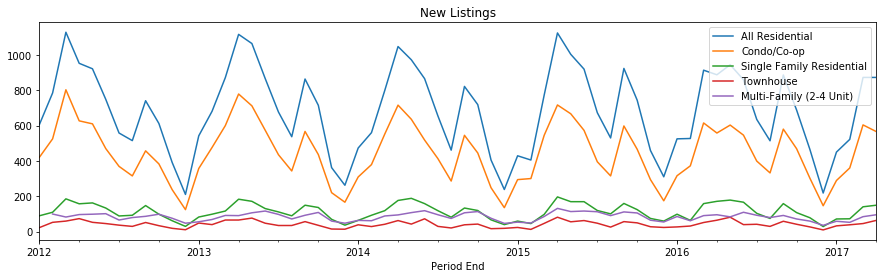

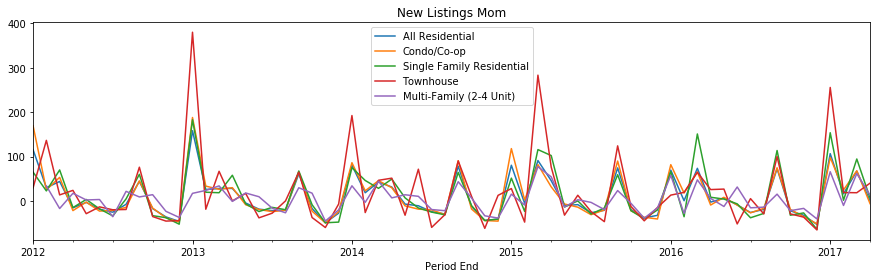

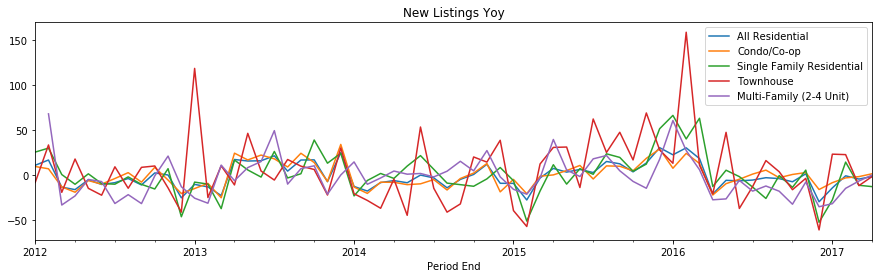

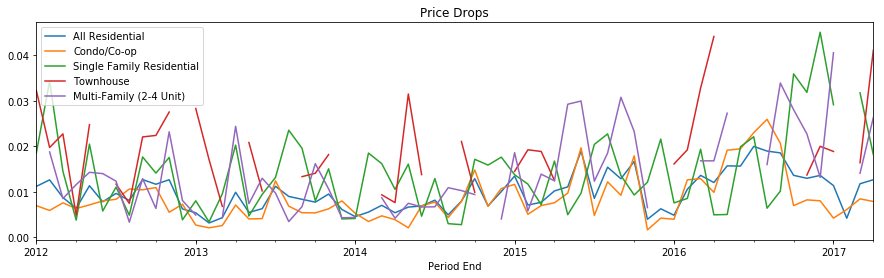

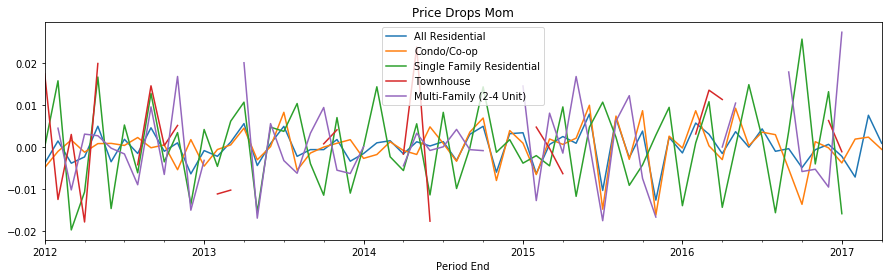

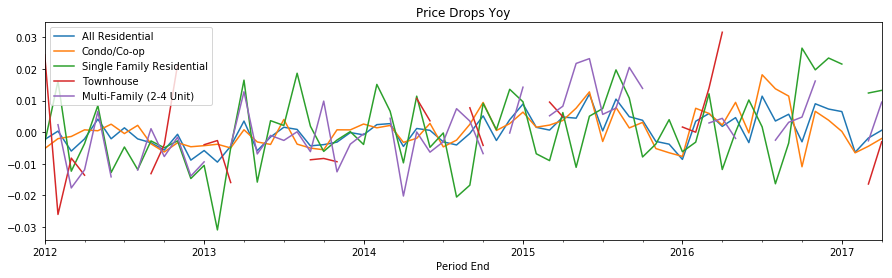

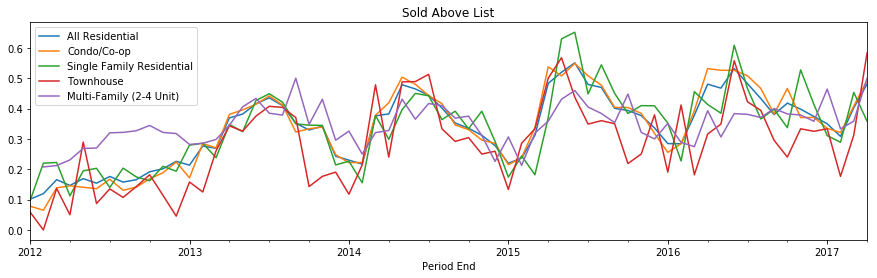

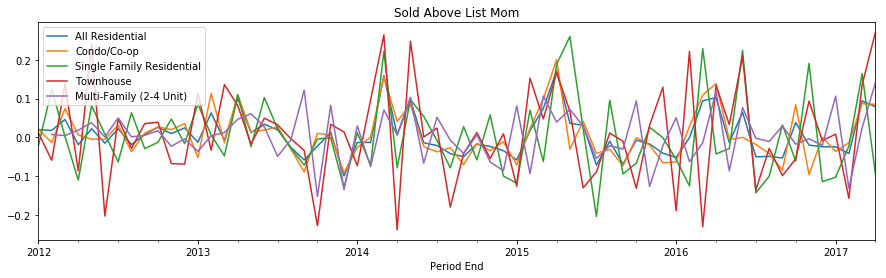

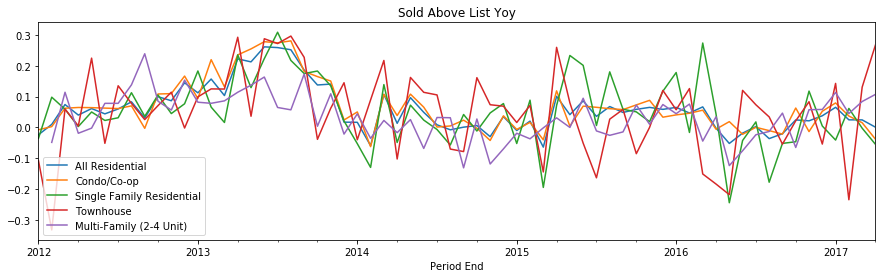

In [570]:
#for target in [col for col in bc_full_df.columns if 'Yoy' not in col and 'Mom' not in col and bc_full_df[col].dtype != 'object']:
for target in [col for col in df.columns if df[col].dtype != 'object']:
    plt.figure()
    #target='Median Dom'
    labels=[]
    for prop_type in df['Property Type'].unique():
        labels.append(prop_type)
        #mask for each plot
        mask = ((df['Region'] == 'Boston, MA') &
               (df['Property Type'] == prop_type))
        #plot
        ax = df[mask][target].plot(figsize=(15,4),title=target)
        ax.legend(labels=labels)

# Transform in attempt to make all additive
Log transform
    - Inventory, months_of_supply

In [1014]:
bos['Inventory'] = np.log(bos['Inventory'])
bos['months_of_supply'] = np.log(bos['months_of_supply'])

In [994]:
2.71828**(np.log(10))

9.9999845116107853

# Decompose columns

In [996]:
#[(col,'add') for col in bos.columns if re.findall(r'Mom\b|mom\b',col)]
#[(col,'add') for col in bos.columns if 'Yoy' not in col and 'yoy' not in col and 'Mom' not in col and 'mom' not in col]

In [997]:
feat_decomp = [('Avg Sale To List', 'add'),
 ('Homes Sold', 'add'),
 ('Inventory', 'add'),
 ('Median Dom', 'add'),
 ('Median List Ppsf', 'add'),
 ('Median List Price', 'add'),
 ('Median Ppsf', 'add'),
 ('Median Sale Price', 'add'),
 ('months_of_supply', 'add'),
 ('New Listings', 'add'),
 ('Price Drops', 'add'),
 ('Sold Above List', 'add'),
 ('Avg Sale To List Yoy', 'add'),
 ('Homes Sold Yoy', 'add'),
 ('Inventory Yoy', 'add'),
 ('Median Dom Yoy', 'add'),
 ('Median List Ppsf Yoy', 'add'),
 ('Median List Price Yoy', 'add'),
 ('Median Ppsf Yoy', 'add'),
 ('Median Sale Price Yoy', 'add'),
 ('months_of_supply_yoy', 'add'),
 ('New Listings Yoy', 'add'),
 ('Price Drops Yoy', 'add'),
 ('Sold Above List Yoy', 'add'),
 ('Avg Sale To List Mom', 'add'),
 ('Homes Sold Mom', 'add'),
 ('Inventory Mom', 'add'),
 ('Median Dom Mom', 'add'),
 ('Median List Ppsf Mom', 'add'),
 ('Median List Price Mom', 'add'),
 ('Median Ppsf Mom', 'add'),
 ('Median Sale Price Mom', 'add'),
 ('months_of_supply_mom', 'add'),
 ('New Listings Mom', 'add'),
 ('Price Drops Mom', 'add'),
 ('Sold Above List Mom', 'add')]

In [1015]:
for seas_col,d_type in feat_decomp:
    #print(seas_col)
    bos = pd.concat([bos,decomp(bos[seas_col],resid=True,model=d_type)],axis=1) #trend=True,seas=True,
    bos.drop(seas_col,axis=1,inplace=True)

In [1001]:
fig.figsize=(3,3)

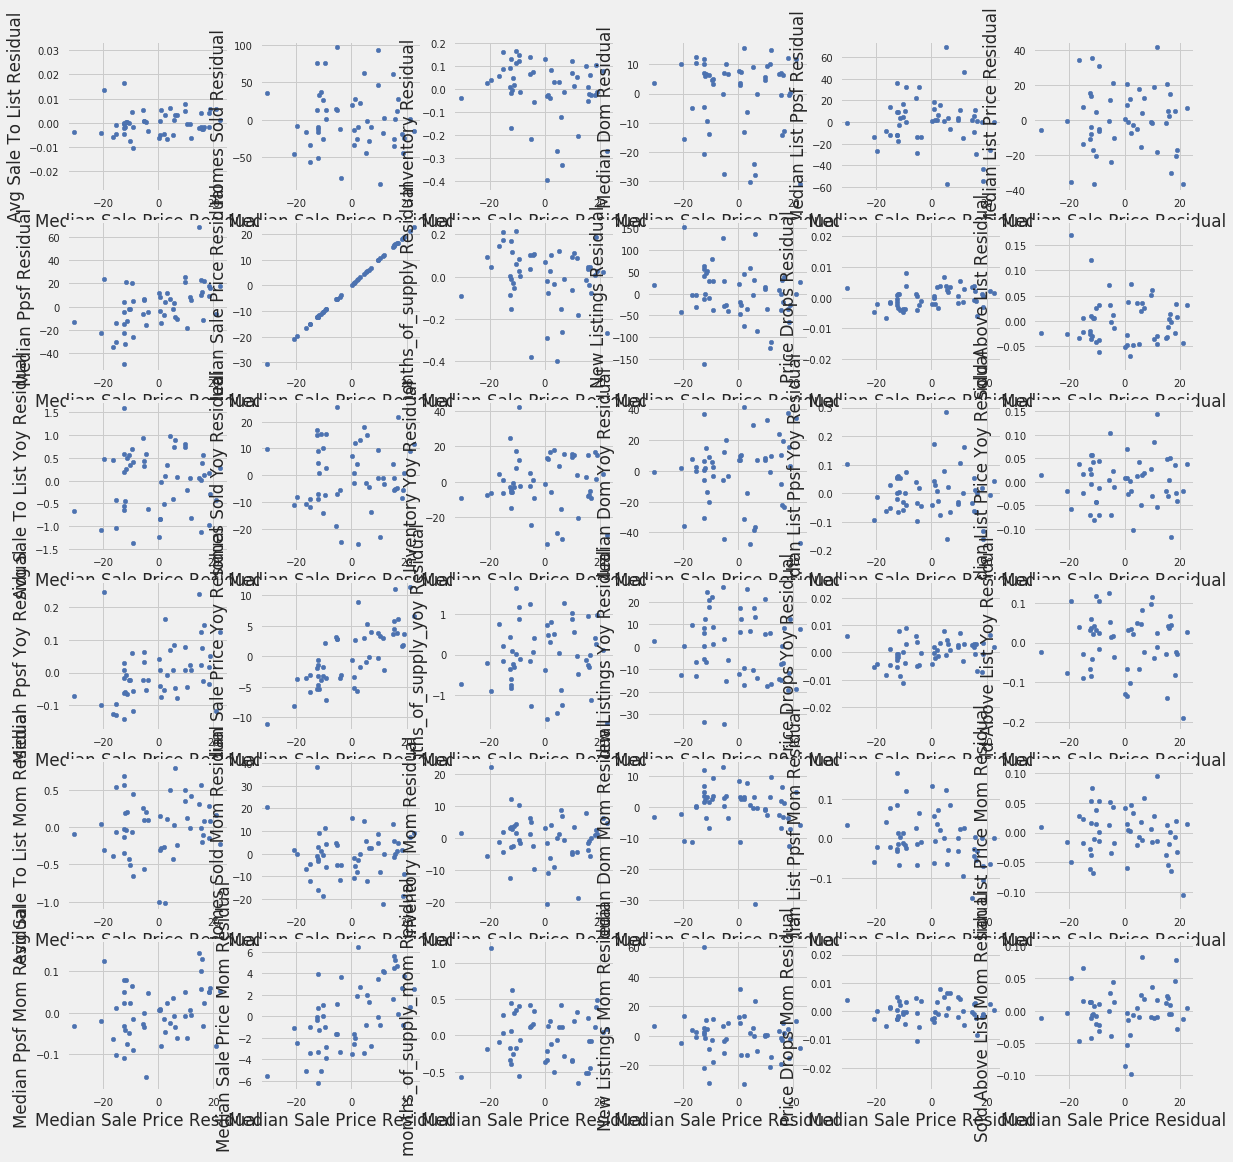

In [1002]:
import re
import seaborn as sns
fig, axes = plt.subplots(nrows=6, ncols=6)

thing = [col for col in bos.columns if re.findall(r'Residual\b',col)]

for i, ax in enumerate(axes.reshape(-1)):
    bos.plot(x='Median Sale Price Residual',y=thing[i],kind='scatter',ax=ax,figsize=(18,18))
    #sns.jointplot('Median Sale Price Residual T+1',thing[i],bos,kind='reg')

# Set mean to 0 for residuals

In [1016]:
mean_resid_dict = {}
for col in [col for col in bos.columns if re.findall(r'Residual\b',col)]:
    mean_resid_dict[col] = bos[col].mean()
    bos[col] = bos[col] - bos[col].mean()

# Lag target variable by T-1, push forward others by T+1,2,3,12,13,14,15

In [1021]:
#bos_copy = bos.copy()
#bos = bos_copy.copy()

In [1022]:
target = 'Median Sale Price Residual'
for col in [col for col in bos.columns if target not in col]:
    for t in range(1,16):
        bos[col+' T-'+str(t)] = bos[col].shift(t)
    
#     bos[col+str(' T+1')] = bos[col].shift(1)
#     bos[col+str(' T+2')] = bos[col].shift(2)
#     bos[col+str(' T+3')] = bos[col].shift(3)
#     bos[col+str(' T+4')] = bos[col].shift(4)
#     bos[col+str(' T+5')] = bos[col].shift(5)
#     bos[col+str(' T+6')] = bos[col].shift(6)
#     bos[col+str(' T+7')] = bos[col].shift(7)
#     bos[col+str(' T+8')] = bos[col].shift(8)
#     bos[col+str(' T+9')] = bos[col].shift(9)
#     bos[col+str(' T+10')] = bos[col].shift(10)
#     bos[col+str(' T+11')] = bos[col].shift(11)
#     bos[col+str(' T+12')] = bos[col].shift(12)
#     bos[col+str(' T+13')] = bos[col].shift(13)
#     bos[col+str(' T+14')] = bos[col].shift(14)
#     bos[col+str(' T+15')] = bos[col].shift(15)
    
for f in range(1,16):
    bos[target+' T+'+str(f)] = bos[target].shift(f)
#     bos[target+' T+1'] = bos[target].shift(-1)
#     bos[target+' T+2'] = bos[target].shift(-2)
#     bos[target+' T+3'] = bos[target].shift(-3)

bos.drop(target,axis=1,inplace=True)    
bos = bos.dropna(axis=0)

# Feature Engineering

In [1023]:
bos['Median Sale Price Residual Diff T1-2'] = bos['Median Sale Price Residual T+1'] - bos['Median Sale Price Residual T+2']
bos['Median Sale Price Residual Diff T2-3'] = bos['Median Sale Price Residual T+2'] - bos['Median Sale Price Residual T+3']

In [1025]:
bos[['Median Sale Price Residual T+1','Median Sale Price Residual T+2','Median Sale Price Residual Diff T1-2']].tail()

Median Sale Price Residual T+1  Median Sale Price Residual T+2  \
Period End                                                                   
2016-12-31                      -11.645833                       -4.343750   
2017-01-31                       -5.197917                      -11.645833   
2017-02-28                       16.350000                       -5.197917   
2017-03-31                      -16.566667                       16.350000   
2017-04-30                      -12.466667                      -16.566667   

            Median Sale Price Residual Diff T1-2  
Period End                                        
2016-12-31                             -7.302083  
2017-01-31                              6.447917  
2017-02-28                             21.547917  
2017-03-31                            -32.916667  
2017-04-30                              4.100000

In [1032]:
top_feat = list(bos.corr()['Median Sale Price Residual T+1'].abs().sort_values(ascending=False).head(10).index)

# Set dependent variables and target

In [1033]:
target = 'Median Sale Price Residual T+1'
y = bos[target]
X = bos.drop([target],axis=1)

In [416]:
# y = bos['Median Sale Price T-2']
# X = bos.drop(['Median Sale Price T-2'],axis=1)

In [1051]:
X.shape

(25, 576)

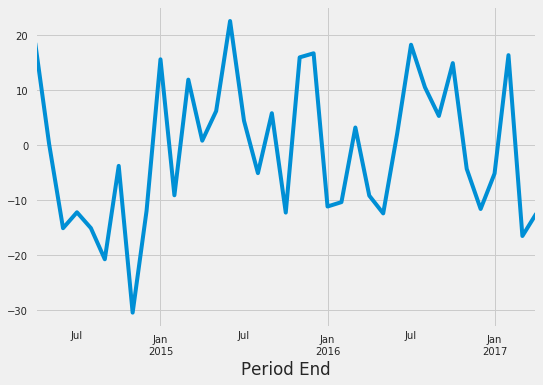

In [1034]:
y.plot()

# Normal Supervised learning with median house lag T-1

In [642]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
import numpy as np
%matplotlib inline

# Timeseries/Regular Test Train split

In [645]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=4)
for train, test in tscv.split(X):
    print("%s %s" % (train, test))

[0 1 2 3 4 5 6 7 8 9] [10 11 12 13 14 15]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] [16 17 18 19 20 21]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21] [22 23 24 25 26 27]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27] [28 29 30 31 32 33]


In [1052]:
#holdout
# X, X_hold, y, y_hold = train_test_split(X,y,test_size=0.3)
# X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

#when seasonality not removed
# X_train = X.iloc[train]
# y_train = y.iloc[train]
# X_test = X.iloc[test]
# y_test = y.iloc[test]

#
X_train = X[:'2016-04-30']
y_train = y[:'2016-04-30']
X_test = X['2016-04-30':]
y_test = y['2016-04-30':]

In [1053]:
print(bos.shape)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(37, 577)
(15, 576)
(10, 576)
(15,)
(10,)


In [1054]:
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor

In [1055]:
#reg = BayesianRidge(n_iter=500)
#reg = AdaBoostRegressor(DecisionTreeRegressor(max_depth=10),n_estimators=100)
#reg = LinearSVR(C=.01, epsilon=5)
#reg = SVR(kernel='rbf', C=10, gamma=1)
reg = RandomForestRegressor(n_estimators=200)
#reg = LinearRegression()
#reg = Lasso(alpha=5)
#reg = ElasticNet(l1_ratio=.7)

In [1080]:
reg.fit(X_train,y_train)
y_pred = reg.predict(X_test)
score = cross_val_score(reg,X,y,scoring='neg_mean_squared_error',cv=tscv)
np.sqrt(-score).mean()

14.093916402782799

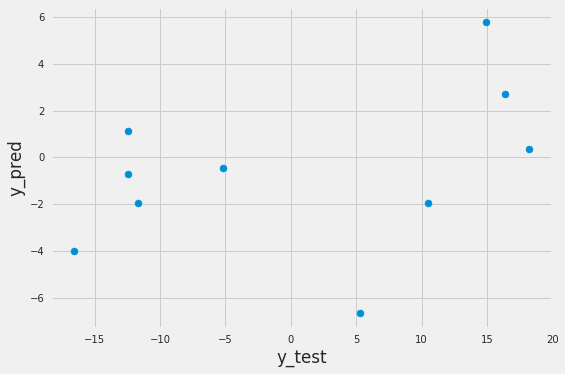

In [1082]:
plt.scatter(y_test,y_pred)
plt.ylabel('y_pred')
plt.xlabel('y_test')

In [1085]:
r2_score(y_test,y_pred)
#y_test-y_pred

0.12883449609620634

In [1086]:
importance = pd.DataFrame(list(zip(X.columns,reg.feature_importances_)))
#importance = pd.DataFrame(list(zip(X.columns,reg.coef_)))

In [1087]:
importance.columns = ['col','coef']

In [1088]:
importance.sort_values(by='coef',ascending=False).head(10)

col      coef
30         Median Sale Price Mom Residual  0.074822
352          Price Drops Yoy Residual T-3  0.062530
418            Inventory Mom Residual T-9  0.054330
545      Sold Above List Mom Residual T-1  0.035168
125              Median Ppsf Residual T-1  0.032963
574  Median Sale Price Residual Diff T1-2  0.027136
508     months_of_supply_mom Residual T-9  0.022715
109        Median List Ppsf Residual T-15  0.022458
482         Median Ppsf Mom Residual T-13  0.019790
454    Median List Ppsf Mom Residual T-15  0.015910

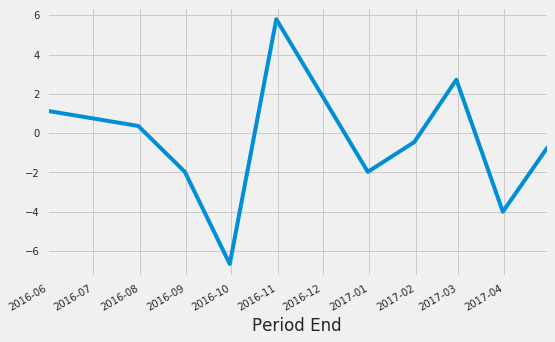

In [1105]:
a = pd.Series(y_pred)
a.index = y_test.index
a.plot()

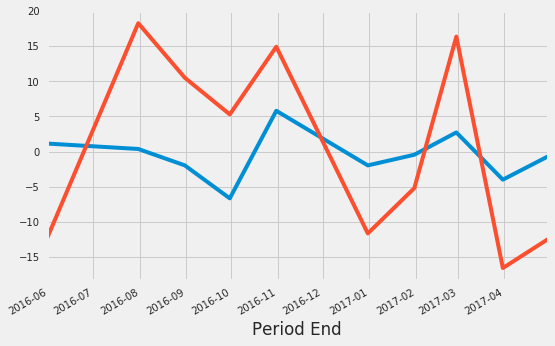

In [1107]:
a.plot()
pd.Series(y_test).plot()

In [1095]:
mean_resid_dict['Median Sale Price Residual']

21.606597222222263

In [1097]:
resid_pred = y_pred + mean_resid_dict['Median Sale Price Residual']

# Stats Model ARIMA

In [756]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [927]:
p = q = range(0,15)
d = range(0,3)
pdq = list(itertools.product(p,d,q))
sp = sq = range(0,2)
sd = range(0,2)
s = 12
seasonal_pdq = [(x[0],x[1],x[2],s) for x in list(itertools.product(sp,sd,sq))]

In [928]:
#ARIMA(2, 2, 1)x(2, 2, 0, 12)12 - AIC:121.59367522968692
#warnings.filterwarnings("ignore") # specify to ignore warning messages
results_list = []

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(bos_arima['Median Sale Price'],
                                            order=param,
                                            #seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            results_list.append((param, param_seasonal, results.aic))
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            print('FAILED ARIMA{}x{}12'.format(param, param_seasonal))
            continue

FAILED ARIMA(0, 0, 0)x(0, 0, 0, 12)12
FAILED ARIMA(0, 0, 0)x(0, 0, 1, 12)12
FAILED ARIMA(0, 0, 0)x(0, 1, 0, 12)12
FAILED ARIMA(0, 0, 0)x(0, 1, 1, 12)12
FAILED ARIMA(0, 0, 0)x(1, 0, 0, 12)12
FAILED ARIMA(0, 0, 0)x(1, 0, 1, 12)12
FAILED ARIMA(0, 0, 0)x(1, 1, 0, 12)12
FAILED ARIMA(0, 0, 0)x(1, 1, 1, 12)12
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:869.050751443
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:869.050751443
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:869.050751443
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:869.050751443
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:869.050751443
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:869.050751443
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:869.050751443
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:869.050751443
ARIMA(0, 0, 2)x(0, 0, 0, 12)12 - AIC:787.257519035
ARIMA(0, 0, 2)x(0, 0, 1, 12)12 - AIC:787.257519035
ARIMA(0, 0, 2)x(0, 1, 0, 12)12 - AIC:787.257519035
ARIMA(0, 0, 2)x(0, 1, 1, 12)12 - AIC:787.257519035
ARIMA(0, 0, 2)x(1, 0, 0, 12)12 - AIC:787.257519035
ARIMA(0, 0, 2)x(1, 0, 1, 12)12 - 

In [929]:
#best pdq
results_df = pd.DataFrame(results_list)
#best pdq
results_df.iloc[results_df[2].idxmin()]

0       (14, 2, 1)
1    (0, 0, 0, 12)
2           419.31
Name: 5248, dtype: object

In [930]:
results_df.to_csv('ARIMA_gridsearch.csv',index=False)

# RMSE of Baselines and Standard ARIMA:

1. Simple Trend and Trend+Seasonality
    - Trend: __728 RMSE__
    - Trend+MeanResid: __523 RMSE__ (__525 RMSE__ multi)
    - Trend+Seasonality+MeanResid: __384 RMSE__ (__377 RMSE__ multi)
2. ARIMA and SARIMA
    - ARIMA: __418 RMSE__ (1,2,13) and (13,2,1)
    - SARIMA: __403 RMSE__ (13,2,1)(0,0,0,12)
3. ARIMA + Residuals
    - ARIMA+
    
    
# Residual mean != 0, so can add to predictions

In [941]:
decomposition = sm.tsa.seasonal_decompose(bos_arima['Median Sale Price'], model='add', two_sided=False, freq=12)

In [942]:
mean_resid = (decomposition.resid).mean()
mean_resid

21.606597222222263

In [943]:
#trend+mean_resid
y = bos_arima['2014-07-31':]['Median Sale Price']
y_pred = (decomposition.trend+mean_resid)
np.sqrt((y-y_pred)**2).sum()

523.55138888888916

In [944]:
#trend+seasonality+mean_resid
y = bos_arima['2014-07-31':]['Median Sale Price']
y_pred = (decomposition.trend+decomposition.seasonal+mean_resid)
np.sqrt((y-y_pred)**2).sum()

384.20416666666711

In [937]:
#param = (1,2,13) #gridsearched: 1,2,13
param = (13,2,1)
#param_seasonal = (1,1,1,12)
mod = sm.tsa.statespace.SARIMAX(bos_arima['Median Sale Price'],
                                order=param,
                                #seasonal_order=param_seasonal,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()

In [938]:
y = bos_arima['2014-07-31':]['Median Sale Price']
y_pred = results.predict(start=pd.to_datetime('2014-07-31'),dynamic=False)
np.sqrt((y-y_pred)**2).sum()

403.64877108292632

In [1100]:
#results.predict(start=pd.to_datetime('2014-07-31'),dynamic=False).plot()
(bos_arima['2014-07-31':]['Median Sale Price']).plot(figsize=(4,4))

ValueError: operands could not be broadcast together with shapes (13,) (10,) 

# Test stationarity

In [831]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    fig = plt.figure(figsize=(6, 5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

# 3 steps: Lag(1) Diff, Lag(12) Diff

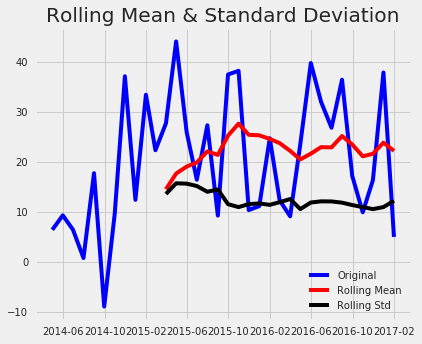

Results of Dickey-Fuller Test:
Test Statistic                 -4.626370
p-value                         0.000115
#Lags Used                      0.000000
Number of Observations Used    33.000000
Critical Value (5%)            -2.954127
Critical Value (1%)            -3.646135
Critical Value (10%)           -2.615968
dtype: float64


In [837]:
test_stationarity(bos['Median Sale Price Residual T+1'])
#test_stationarity((bos_arima['Median Sale Price']-bos_arima['Median Sale Price'].shift(1)).dropna(axis=0))
#bos_arima['Median Sale Price Diff Lag1'] = (bos_arima['Median Sale Price']-bos_arima['Median Sale Price'].shift(1)).dropna(axis=0)
#test_stationarity((bos_arima['Median Sale Price Diff Lag1']-bos_arima['Median Sale Price Diff Lag1'].shift(12)).dropna(axis=0))

# Finding optimal params for ARIMA

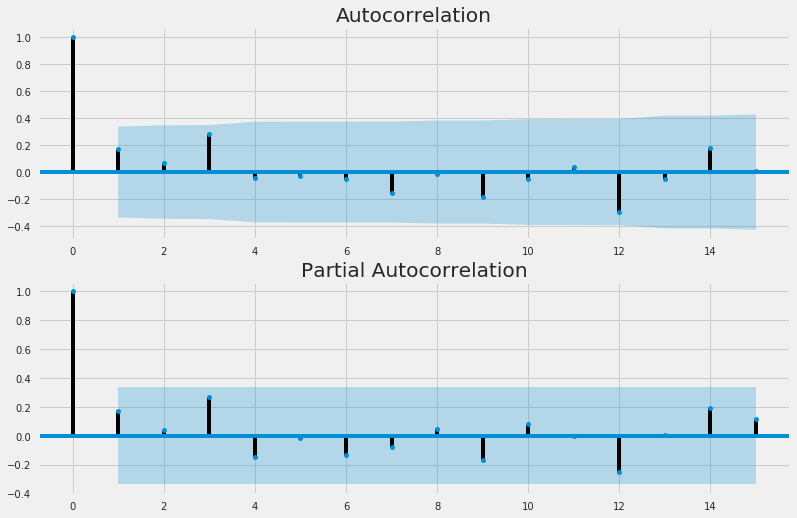

In [845]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(bos['Median Sale Price Residual T+1'], lags=15, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(bos['Median Sale Price Residual T+1'], lags=15, ax=ax2)

In [865]:
#bos['Median Sale Price Residual T+1']

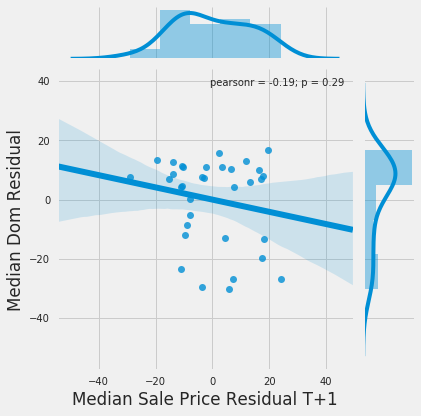

In [989]:
sns.jointplot(x='Median Sale Price Residual T+1',y='Median Dom Residual',data=bos,kind='reg')